In [1]:
import numpy as np
import random

In [2]:
def softmax(x):
    """
    Compute the softmax function for each row of the input x.

    It is crucial that this function is optimized for speed because
    it will be used frequently in later code.
    You might find numpy functions np.exp, np.sum, np.reshape,
    np.max, and numpy broadcasting useful for this task. (numpy
    broadcasting documentation:
    http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)

    You should also make sure that your code works for one
    dimensional inputs (treat the vector as a row), you might find
    it helpful for your later problems.

    You must implement the optimization in problem 1(a) of the 
    written assignment!
    """

    ### YOUR CODE HERE
    
    if x.ndim == 1:
        x -= np.min(x)  # solving overflow problem
        x = np.exp(x)
        x /= np.sum(x)
    else:
        x -= np.min(x, axis=1, keepdims=True)  # solving overflow problem
        x = np.exp(x)
        x /= np.sum(x, axis=1, keepdims=True)

    ### END YOUR CODE
    
    return x

In [3]:
def test_softmax_basic():
    """
    Some simple tests to get you started. 
    Warning: these are not exhaustive.
    """
    print("Running basic tests...")
    test1 = softmax(np.array([1,2]))
    print(test1)
    assert np.amax(np.fabs(test1 - np.array(
        [0.26894142,  0.73105858]))) <= 1e-6

    test2 = softmax(np.array([[1001,1002],[3,4]]))
    print(test2)
    assert np.amax(np.fabs(test2 - np.array(
        [[0.26894142, 0.73105858], [0.26894142, 0.73105858]]))) <= 1e-6

    test3 = softmax(np.array([[-1001,-1002]]))
    print(test3)
    assert np.amax(np.fabs(test3 - np.array(
        [0.73105858, 0.26894142]))) <= 1e-6

    print("You should verify these results!\n")

In [4]:
test_softmax_basic()

Running basic tests...
[ 0.26894142  0.73105858]
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]
[[ 0.73105858  0.26894142]]
You should verify these results!



In [5]:
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        ### try modifying x[ix] with h defined above to compute numerical gradients
        ### make sure you call random.setstate(rndstate) before calling f(x) each time, this will make it 
        ### possible to test cost functions with built in randomness later
        ### YOUR CODE HERE:
        
        random.setstate(rndstate)
        tmp1 = np.copy(x) 
        tmp1[ix] = tmp1[ix] + h
        f1, _ = f(tmp1)
        
        random.setstate(rndstate)
        tmp2 = np.copy(x) 
        tmp2[ix] = tmp2[ix] - h
        f2, _ = f(tmp2)
        numgrad = (f1 - f2) / (2 * h)
        
        ### END YOUR CODE

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print("Gradient check failed.")
            print("First gradient error found at index %s" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad))
            return
    
        it.iternext() # Step to next dimension

    print("Gradient check passed!")

In [6]:
def sanity_check():
    """
    Some basic sanity checks.
    """
    quad = lambda x: (np.sum(x ** 2), x * 2)

    print("Running sanity checks...")
    gradcheck_naive(quad, np.array(123.456))      # scalar test
    gradcheck_naive(quad, np.random.randn(3,))    # 1-D test
    gradcheck_naive(quad, np.random.randn(4,5))   # 2-D test
    print("")

In [7]:
sanity_check()

Running sanity checks...
Gradient check passed!
Gradient check passed!
Gradient check passed!



In [8]:
import numpy as np

def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    
    ### YOUR CODE HERE
    
    x = 1. / (1. + np.exp(-x))
    
    ### END YOUR CODE
    
    return x

def sigmoid_grad(f):
    """
    Compute the gradient for the sigmoid function here. Note that
    for this implementation, the input f should be the sigmoid
    function value of your original input x. 
    """
    
    ### YOUR CODE HERE
    
    f = f * (1 - f)
    
    ### END YOUR CODE
    
    return f

def test_sigmoid_basic():
    """
    Some simple tests to get you started. 
    Warning: these are not exhaustive.
    """
    print("Running basic tests...")
    x = np.array([[1, 2], [-1, -2]])
    f = sigmoid(x)
    g = sigmoid_grad(f)
    print(f)
    assert np.amax(f - np.array([[0.73105858, 0.88079708], 
        [0.26894142, 0.11920292]])) <= 1e-6
    print(g)
    assert np.amax(g - np.array([[0.19661193, 0.10499359],
        [0.19661193, 0.10499359]])) <= 1e-6
    print("You should verify these results!\n")

def test_sigmoid(): 
    """
    Use this space to test your sigmoid implementation by running:
        python q2_sigmoid.py 
    This function will not be called by the autograder, nor will
    your tests be graded.
    """
    print("Running your tests...")
    ### YOUR CODE HERE
    
    ### END YOUR CODE

if __name__ == "__main__":
    test_sigmoid_basic();
    test_sigmoid()


Running basic tests...
[[ 0.73105858  0.88079708]
 [ 0.26894142  0.11920292]]
[[ 0.19661193  0.10499359]
 [ 0.19661193  0.10499359]]
You should verify these results!

Running your tests...


In [9]:
# Save parameters every a few SGD iterations as fail-safe
SAVE_PARAMS_EVERY = 1000

import glob
import random
import numpy as np
import os.path as op
import pickle as pickle

def load_saved_params():
    """ A helper function that loads previously saved parameters and resets iteration start """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter
            
    if st > 0:
        with open("saved_params_%d.npy" % st, "rb") as f:
            params = pickle.load(f)
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None
    
def save_params(iter, params):
    with open("saved_params_%d.npy" % iter, "wb") as f:
        pickle.dump(params, f)
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing = None, useSaved = False, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    # Implement the stochastic gradient descent method in this        
    # function.                                                       
    
    # Inputs:                                                         
    # - f: the function to optimize, it should take a single        
    #     argument and yield two outputs, a cost and the gradient  
    #     with respect to the arguments                            
    # - x0: the initial point to start SGD from                     
    # - step: the step size for SGD                                 
    # - iterations: total iterations to run SGD for                 
    # - postprocessing: postprocessing function for the parameters  
    #     if necessary. In the case of word2vec we will need to    
    #     normalize the word vectors to have unit length.          
    # - PRINT_EVERY: specifies every how many iterations to output  

    # Output:                                                         
    # - x: the parameter value after SGD finishes  
    
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000
    
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx;
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)
            
        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x = x0
    
    if not postprocessing:
        postprocessing = lambda x: x
    
    expcost = None
    
    for iter in range(start_iter + 1, iterations + 1):
        ### Don't forget to apply the postprocessing after every iteration!
        ### You might want to print the progress every few iterations.

        cost = None
        ### YOUR CODE HERE
        cost, grad = f(x)
        x -= step * grad

        x = postprocessing(x)
        ### END YOUR CODE
        
        if PRINT_EVERY is not None and iter % PRINT_EVERY == 0:
            if not expcost:
                expcost = cost
            else:
                expcost = .95 * expcost + .05 * cost
            print("iter %d: %f" % (iter, expcost))
        
        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)
            
        if iter % ANNEAL_EVERY == 0:
            step *= 0.5
    
    return x

def sanity_check():
    quad = lambda x: (np.sum(x ** 2), x * 2)

    print("Running sanity checks...")
    t1 = sgd(quad, 0.5, 0.01, 1000, PRINT_EVERY=None)
    print("test 1 result:", t1)
    assert abs(t1) <= 1e-6

    t2 = sgd(quad, 0.0, 0.01, 1000, PRINT_EVERY=None)
    print("test 2 result:", t2)
    assert abs(t2) <= 1e-6

    t3 = sgd(quad, -1.5, 0.01, 1000, PRINT_EVERY=None)
    print("test 3 result:", t3)
    assert abs(t3) <= 1e-6
    
    print("")

def your_sanity_checks(): 
    """
    Use this space add any additional sanity checks by running:
        python q3_sgd.py 
    This function will not be called by the autograder, nor will
    your additional tests be graded.
    """
    print("Running your sanity checks...")
    ### YOUR CODE HERE
    #raise NotImplementedError
    ### END YOUR CODE

if __name__ == "__main__":
    sanity_check();
    your_sanity_checks();
 

Running sanity checks...
test 1 result: 8.414836786079764e-10
test 2 result: 0.0
test 3 result: -2.524451035823933e-09

Running your sanity checks...


In [10]:
import numpy as np
import random

from q1_softmax import softmax
from q2_sigmoid import sigmoid, sigmoid_grad
from q2_gradcheck import gradcheck_naive
def forward_backward_prop(data, labels, params, dimensions):
    """ 
    Forward and backward propagation for a two-layer sigmoidal network 
    
    Compute the forward propagation and for the cross entropy cost,
    and backward propagation for the gradients for all parameters.
    """

    ### Unpack network parameters (do not modify)
    ofs = 0
    Dx, H, Dy = (dimensions[0], dimensions[1], dimensions[2]) # (dim_x, dim_h, dim_y)

    W1 = np.reshape(params[ofs:ofs+ Dx * H], (Dx, H)) # (dim_x, dim_h)
    ofs += Dx * H
    b1 = np.reshape(params[ofs:ofs + H], (1, H)) # (1, dim_h)
    ofs += H
    W2 = np.reshape(params[ofs:ofs + H * Dy], (H, Dy)) # (dim_h, dim_y)
    ofs += H * Dy
    b2 = np.reshape(params[ofs:ofs + Dy], (1, Dy)) # (1, dim_y)
 
    
    ### YOUR CODE HERE: forward propagation
    
    h = sigmoid(np.dot(data, W1) + b1)  
    pred = sigmoid(np.dot(h, W2) + b2) 
    cost = (-1) * np.sum(labels * np.log(pred) + (1 - labels) * np.log(1 - pred))  # sigmoid 함수를 썼을 때 cost function
    
    ### END YOUR CODE
    
    
    ### YOUR CODE HERE: backward propagation
    
    dout = pred - labels 
    dh = np.dot(dout, W2.T) * sigmoid_grad(h)  
    
    gradW2 = np.dot(h.T, dout) 
    gradb2 = np.sum(dout, 0)  
    gradW1 = np.dot(data.T, dh)
    gradb1 = np.sum(dh, 0)
    
    ### END YOUR CODE

    ### Stack gradients (do not modify)
    grad = np.concatenate((gradW1.flatten(), gradb1.flatten(), 
        gradW2.flatten(), gradb2.flatten()))
    
    return cost, grad

def sanity_check():
    """
    Set up fake data and parameters for the neural network, and test using 
    gradcheck.
    """
    print("Running sanity check...")

    N = 20
    dimensions = [10, 5, 10]
    data = np.random.randn(N, dimensions[0])   # each row will be a datum
    labels = np.zeros((N, dimensions[2]))
    for i in range(N):
        labels[i,random.randint(0,dimensions[2]-1)] = 1  # one-hot labels
    
    params = np.random.randn((dimensions[0] + 1) * dimensions[1] + (
        dimensions[1] + 1) * dimensions[2], )

    gradcheck_naive(lambda params: forward_backward_prop(data, labels, params,
        dimensions), params)


def your_sanity_checks(): 
    """
    Use this space add any additional sanity checks by running:
        python q2_neural.py 
    This function will not be called by the autograder, nor will
    your additional tests be graded.
    """
    print("Running your sanity checks...")
    ### YOUR CODE HERE
    #raise NotImplementedError
    ### END YOUR CODE

if __name__ == "__main__":
    sanity_check()
    your_sanity_checks()

Running sanity check...
Gradient check passed!
Running your sanity checks...


In [11]:
import numpy as np
import random

from q1_softmax import softmax
from q2_gradcheck import gradcheck_naive
from q2_sigmoid import sigmoid, sigmoid_grad

def normalizeRows(x):
    """ Row normalization function """
    # Implement a function that normalizes each row of a matrix to have unit length
    
    ### YOUR CODE HERE
    
    
    x_sum = np.sqrt(np.sum(x**2, 1))
    x /= np.reshape(x_sum, (-1, 1)) + 1e-20
    
    
    ### END YOUR CODE
    
    return x

def test_normalize_rows():
    print("Testing normalizeRows...")
    x = normalizeRows(np.array([[3.0,4.0],[1, 2]])) 
    # the result should be [[0.6, 0.8], [0.4472, 0.8944]]
    print(x)
    assert (x.all() == np.array([[0.6, 0.8], [0.4472, 0.8944]]).all())
    print("")

def softmaxCostAndGradient(predicted, target, outputVectors, dataset):
    """ Softmax cost function for word2vec models """
    
    # Implement the cost and gradients for one predicted word vector  
    # and one target word vector as a building block for word2vec     
    # models, assuming the softmax prediction function and cross      
    # entropy loss.                                                   
    
    # Inputs:                                                         
    # - predicted: numpy ndarray, predicted word vector (\hat{v} in 
    #   the written component or \hat{r} in an earlier version)
    # - target: integer, the index of the target word               
    # - outputVectors: "output" vectors (as rows) for all tokens     
    # - dataset: needed for negative sampling, unused here.         
    
    # Outputs:                                                        
    # - cost: cross entropy cost for the softmax word prediction    
    # - gradPred: the gradient with respect to the predicted word   
    #        vector                                                
    # - grad: the gradient with respect to all the other word        
    #        vectors                                               
    
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!                                                  
    
    ### YOUR CODE HERE
    
    N = outputVectors.shape[0]                     # n_words: vocab size
    y = np.zeros(N)
    y[target] = 1                                     # (n_words)
    
    score = np.dot(predicted, outputVectors.T)               # (1, n_words)
    out = softmax(score)
    
    cost = np.sum(-y * np.log(out))         
    
    dout = out - y                            # (1, n_words)
    gradPred = np.dot(dout, outputVectors)             # (1, dim_embed)
    grad = np.dot(dout.T, predicted)              # (n_words, dim_embed)
    
    
    ### END YOUR CODE
    
    return cost, gradPred, grad

def negSamplingCostAndGradient(predicted, target, outputVectors, dataset, 
    K=10):
    """ Negative sampling cost function for word2vec models """

    # Implement the cost and gradients for one predicted word vector  
    # and one target word vector as a building block for word2vec     
    # models, using the negative sampling technique. K is the sample  
    # size. You might want to use dataset.sampleTokenIdx() to sample  
    # a random word index. 
    # 
    # Note: See test_word2vec below for dataset's initialization.
    #                                       
    # Input/Output Specifications: same as softmaxCostAndGradient     
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!
    
    cost = 0.0
    grad = np.zeros_like(outputVectors)
    gradPred = np.zeros_like(predicted)
    
    ### YOUR CODE HERE
    
    
    a_target = sigmoid(np.dot(predicted.reshape(-1), outputVectors[target].T))
    cost += -np.log(a_target)                                # cost for target value
    grad[target:target+1] = (a_target - 1) * predicted        # gradient for target value
    gradPred += (a_target - 1) * outputVectors[target]
    
    neg_samples = []  
    
    for i in range(K):
        j = dataset.sampleTokenIdx()
        if j == target or (j in neg_samples):
            i -= 1           # if negative sample is same with target or already sampled, then resample.
            continue
        neg_samples.append(j)
        
        a_neg = sigmoid(-np.dot(predicted.reshape(-1), outputVectors[j].T))
        cost += -np.log(a_neg)                                              # cost for negative sample
        grad[j:j+1] = (1 - a_neg) * predicted                                # gradient for negative sample
        gradPred += (1 - a_neg) * outputVectors[j] 
    

    ### END YOUR CODE
    
    return cost, gradPred, grad


def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """

    # Implement the skip-gram model in this function.

    # Inputs:                                                         
    # - currrentWord: a string of the current center word           
    # - C: integer, context size                                    
    # - contextWords: list of no more than 2*C strings, the context words                                               
    # - tokens: a dictionary that maps words to their indices in    
    #      the word vector list                                
    # - inputVectors: "input" word vectors (as rows) for all tokens           
    # - outputVectors: "output" word vectors (as rows) for all tokens         
    # - word2vecCostAndGradient: the cost and gradient function for 
    #      a prediction vector given the target word vectors,  
    #      could be one of the two cost functions you          
    #      implemented above

    # Outputs:                                                        
    # - cost: the cost function value for the skip-gram model       
    # - grad: the gradient with respect to the word vectors         
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!

    cost = 0.0
    gradIn = np.zeros(inputVectors.shape) 
    gradOut = np.zeros(outputVectors.shape)
    
    
    ### YOUR CODE HERE
    
    
    idx = tokens[currentWord]                 # tokens['a'] = 1
    input_vector = inputVectors[idx:idx+1]              # (1, dim_embed)   
    
    for context in contextWords:
        c, g_in, g_out = word2vecCostAndGradient(input_vector, tokens[context], outputVectors, dataset)
        cost += c
        gradIn[idx:idx+1, :] += g_in
        gradOut += g_out

        
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

def cbow(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ CBOW model in word2vec """

    # Implement the continuous bag-of-words model in this function.            
    # Input/Output specifications: same as the skip-gram model        
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!

    #################################################################
    # IMPLEMENTING CBOW IS EXTRA CREDIT, DERIVATIONS IN THE WRIITEN #
    # ASSIGNMENT ARE NOT!                                           #  
    #################################################################
    
    cost = 0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)

    ### YOUR CODE HERE
    
    
    for contextWord in contextWords:
        idx = tokens[contextWord]               # tokens['a'] = 1
        input_vector = inputVectors[idx:idx+1]   
        c, g_in, g_out = word2vecCostAndGradient(input_vector, tokens[currentWord], outputVectors, dataset)
        cost += c
        gradIn[idx:idx+1, :] += g_in
        gradOut += g_out
    
    
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

#############################################
# Testing functions below. DO NOT MODIFY!   #
#############################################

def word2vec_sgd_wrapper(word2vecModel, tokens, wordVectors, dataset, C, word2vecCostAndGradient = softmaxCostAndGradient):
    batchsize = 50
    cost = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    inputVectors = wordVectors[:N//2,:]
    outputVectors = wordVectors[N//2:,:]
    for i in range(batchsize):
        C1 = random.randint(1,C)
        centerword, context = dataset.getRandomContext(C1)
        
        if word2vecModel == skipgram:
            denom = 1
        else:
            denom = 1
        
        c, gin, gout = word2vecModel(centerword, C1, context, tokens, inputVectors, outputVectors, dataset, word2vecCostAndGradient)
        cost += c / batchsize / denom
        grad[:N//2, :] += gin / batchsize / denom
        grad[N//2:, :] += gout / batchsize / denom
        
    return cost, grad

def test_word2vec():
    # Interface to the dataset for negative sampling
    dataset = type('dummy', (), {})()
    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0,4)], [tokens[random.randint(0,4)] \
           for i in range(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10,3))
    dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])
    print("==== Gradient check for skip-gram ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5), dummy_vectors)
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)
    print("\n==== Gradient check for CBOW      ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5), dummy_vectors)
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)

    print("\n=== Results ===")
    print(skipgram("c", 3, ["a", "b", "e", "d", "b", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset))
    print(skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset, negSamplingCostAndGradient))
    print(cbow("a", 2, ["a", "b", "c", "a"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset))
    print(cbow("a", 2, ["a", "b", "a", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset, negSamplingCostAndGradient))

if __name__ == "__main__":
    test_normalize_rows()
    test_word2vec()

Testing normalizeRows...
[[ 0.6         0.8       ]
 [ 0.4472136   0.89442719]]

==== Gradient check for skip-gram ====
Gradient check passed!
Gradient check passed!

==== Gradient check for CBOW      ====
Gradient check passed!
Gradient check passed!

=== Results ===
(11.166109001533979, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.26947339, -1.36873189,  2.45158957],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.41045956,  0.18834851,  1.43272264],
       [ 0.38202831, -0.17530219, -1.33348241],
       [ 0.07009355, -0.03216399, -0.24466386],
       [ 0.09472154, -0.04346509, -0.33062865],
       [-0.13638384,  0.06258276,  0.47605228]]))
(5.8426836294645668, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.33855778, -1.24138626,  0.42784661],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.  

sanity check: cost at convergence should be around or below 10


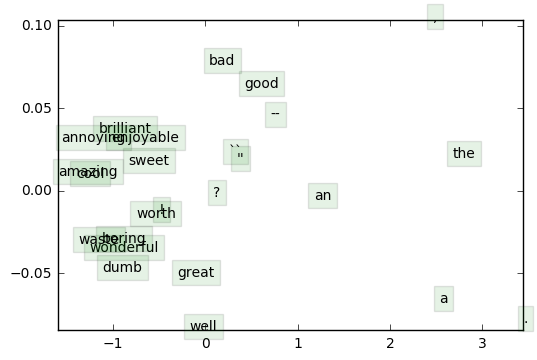

In [12]:
import random
import numpy as np
from cs224d.data_utils import *
import matplotlib.pyplot as plt

from q3_word2vec import *
from q3_sgd import *

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)
wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - .5) / \
	dimVectors, np.zeros((nWords, dimVectors))), axis=0)
wordVectors0 = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, 
    	negSamplingCostAndGradient), 
    wordVectors, 0.3, 10000, None, True, PRINT_EVERY=10)
print("sanity check: cost at convergence should be around or below 10")

# sum the input and output word vectors
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])

# Visualize the word vectors you trained
_, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", 
	"good", "great", "cool", "brilliant", "wonderful", "well", "amazing",
	"worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", 
	"annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], 
    	bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

plt.savefig('q3_word_vectors.png')
plt.show()

In [13]:
import numpy as np
import random

from cs224d.data_utils import *

from q1_softmax import softmax
from q2_gradcheck import gradcheck_naive
from q3_sgd import load_saved_params

def getSentenceFeature(tokens, wordVectors, sentence):
    """ Obtain the sentence feature for sentiment analysis by averaging its word vectors """
    # Implement computation for the sentence features given a sentence.                                                       
    
    # Inputs:                                                         
    # - tokens: a dictionary that maps words to their indices in    
    #          the word vector list                                
    # - wordVectors: word vectors (each row) for all tokens                
    # - sentence: a list of words in the sentence of interest 

    # Output:                                                         
    # - sentVector: feature vector for the sentence    
    
    sentVector = np.zeros((wordVectors.shape[1],))
    
    ### YOUR CODE HERE
    array = np.fromiter( (tokens[word] for word in sentence), dtype='int')
    sentVector = np.mean(wordVectors[array], axis=0)
    ### END YOUR CODE
    
    return sentVector

def softmaxRegression(features, labels, weights, regularization = 0.0, nopredictions = False):
    """ Softmax Regression """
    # Implement softmax regression with weight regularization.
    
    # Inputs:                                                         
    # - features: feature vectors, each row is a feature vector
    # - labels: labels corresponding to the feature vectors
    # - weights: weights of the regressor
    # - regularization: L2 regularization constant
    
    # Output:
    # - cost: cost of the regressor
    # - grad: gradient of the regressor cost with respect to its
    #        weights
    # - pred: label predictions of the regressor (you might find
    #        np.argmax helpful)
    
    prob = softmax(features.dot(weights))
    if len(features.shape) > 1:
        N = features.shape[0]
    else:
        N = 1

    # A vectorized implementation of    1/N * sum(cross_entropy(x_i, y_i)) + 1/2*|w|^2
    cost = np.sum(-np.log(prob[np.arange(N), labels] + 1e-12)) / N
    cost += 0.5 * regularization * np.sum(weights ** 2)
    
    ### YOUR CODE HERE: compute the gradients and predictions
    pred = np.argmax(prob, axis=1)
    dx = prob
    dx[np.arange(N), labels] -= 1
    dx /= N
    # dx is the gradient associated with the loss (softmax layer only)
    grad = np.dot(features.T, dx)
    #backprop the weights
    grad += regularization * weights
    #adding the regularization to the gradient
    ### END YOUR CODE
    
    if nopredictions:
        return cost, grad
    else:
        return cost, grad, pred

def accuracy(y, yhat):
    """ Precision for classifier """
    assert(y.shape == yhat.shape)
    return np.sum(y == yhat) * 100.0 / y.size

def softmax_wrapper(features, labels, weights, regularization = 0.0):
    cost, grad, _ = softmaxRegression(features, labels, weights, 
        regularization)
    return cost, grad

def sanity_check():
    """
    Run python q4_softmaxreg.py.
    """
    random.seed(314159)
    np.random.seed(265)

    dataset = StanfordSentiment()
    tokens = dataset.tokens()
    nWords = len(tokens)

    _, wordVectors0, _ = load_saved_params()
    N = wordVectors0.shape[0]//2
    #assert N == nWords
    wordVectors = (wordVectors0[:N,:] + wordVectors0[N:,:])
    dimVectors = wordVectors.shape[1]

    dummy_weights = 0.1 * np.random.randn(dimVectors, 5)
    dummy_features = np.zeros((10, dimVectors))
    dummy_labels = np.zeros((10,), dtype=np.int32)    
    for i in range(10):
        words, dummy_labels[i] = dataset.getRandomTrainSentence()
        dummy_features[i, :] = getSentenceFeature(tokens, wordVectors, words)
    print("==== Gradient check for softmax regression ====")
    gradcheck_naive(lambda weights: softmaxRegression(dummy_features,
        dummy_labels, weights, 1.0, nopredictions = True), dummy_weights)

    print("\n=== Results ===")
    print(softmaxRegression(dummy_features, dummy_labels, dummy_weights, 1.0))

    dummy_weights  = 0.1 * np.random.randn(40, 10) + 1.0
    dummy_features = np.random.randn(2000, 40)
    dummy_labels   = np.argmax(np.random.randn(2000, 10), axis=1)

    print(-np.log(0.1))#expected correct classification (random) = 1 in 10;
    #cost then becomes -np.log(0.1)
    print(softmaxRegression(dummy_features, dummy_labels, dummy_weights, 0.0)[0])

    dummy_weights  = 0.1 * np.random.randn(40, 80) + 1.0
    dummy_features = np.random.randn(2000, 40)
    dummy_labels   = np.argmax(np.random.randn(2000, 80), axis=1)

    print(-np.log(1./80))#expected correct classification (random) = 1 in 80;
    #cost then becomes -np.log(1./80)
    print(softmaxRegression(dummy_features, dummy_labels, dummy_weights, 0.0)[0])

    dummy_weights  = 0.1 * np.random.randn(40, 1000) + 1.0
    dummy_features = np.random.randn(40000, 40)
    dummy_labels   = np.argmax(np.random.randn(40000, 1000), axis=1)

    print(-np.log(1./1000))#expected correct classification (random) = 1 in 80;
    #cost then becomes -np.log(1./80)
    print(softmaxRegression(dummy_features, dummy_labels, dummy_weights, 0.0)[0])
    print(np.exp(-softmaxRegression(dummy_features, dummy_labels, dummy_weights, 0.0)[0]))


if __name__ == "__main__":
    sanity_check()


==== Gradient check for softmax regression ====
Gradient check passed!

=== Results ===
(1.7197198035178798, array([[ 1.04574436, -0.22392156, -0.2089484 , -0.05144186, -0.13019251],
       [ 0.13035736, -0.13642677, -0.06661226,  0.03975088, -0.02914031],
       [ 0.31652344, -0.15724945, -0.0733285 , -0.06836636, -0.13648043],
       [-0.35224321,  0.3329344 ,  0.12169607,  0.03919428,  0.08952855],
       [-1.04637139,  0.36240193,  0.31686771,  0.25696214,  0.04312799],
       [-0.10855243,  0.02499814,  0.30659762,  0.15581989,  0.09873214],
       [ 0.03505001, -0.21385379, -0.28610887, -0.18439528,  0.04576804],
       [-0.26395267,  0.14052696,  0.08730093,  0.18158638, -0.01655735],
       [ 0.66275649, -0.0438666 , -0.21191675, -0.10284391, -0.19610518],
       [ 0.27787294, -0.08915023,  0.01094335, -0.13142639,  0.02776031]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))
2.30258509299
2.46018404561
4.38202663467
4.57849668347
6.90775527898
7.10925581034
0.00081750314

Training for reg=0.000000
iter 100: 0.001622
iter 200: 0.001621
iter 300: 0.001618
iter 400: 0.001615
iter 500: 0.001611
iter 600: 0.001606
iter 700: 0.001601
iter 800: 0.001595
iter 900: 0.001589
iter 1000: 0.001583
iter 1100: 0.001577
iter 1200: 0.001570
iter 1300: 0.001564
iter 1400: 0.001557
iter 1500: 0.001551
iter 1600: 0.001544
iter 1700: 0.001537
iter 1800: 0.001531
iter 1900: 0.001524
iter 2000: 0.001518
iter 2100: 0.001511
iter 2200: 0.001505
iter 2300: 0.001498
iter 2400: 0.001492
iter 2500: 0.001486
iter 2600: 0.001480
iter 2700: 0.001474
iter 2800: 0.001469
iter 2900: 0.001463
iter 3000: 0.001457
iter 3100: 0.001452
iter 3200: 0.001446
iter 3300: 0.001441
iter 3400: 0.001436
iter 3500: 0.001431
iter 3600: 0.001426
iter 3700: 0.001421
iter 3800: 0.001417
iter 3900: 0.001412
iter 4000: 0.001408
iter 4100: 0.001403
iter 4200: 0.001399
iter 4300: 0.001395
iter 4400: 0.001391
iter 4500: 0.001387
iter 4600: 0.001383
iter 4700: 0.001379
iter 4800: 0.001376
iter 4900: 0.001372
ite

C:\Users\Sandeep\Anaconda3\New folder\assignment1\q1_softmax.py:31: RuntimeWarning: overflow encountered in exp
  x = np.exp(x)
C:\Users\Sandeep\Anaconda3\New folder\assignment1\q1_softmax.py:32: RuntimeWarning: invalid value encountered in true_divide
  x /= np.sum(x, axis=1, keepdims=True)


iter 100: nan
iter 200: nan
iter 300: nan
iter 400: nan
iter 500: nan
iter 600: nan
iter 700: nan
iter 800: nan
iter 900: nan
iter 1000: nan
iter 1100: nan
iter 1200: nan
iter 1300: nan
iter 1400: nan
iter 1500: nan
iter 1600: nan
iter 1700: nan
iter 1800: nan
iter 1900: nan
iter 2000: nan
iter 2100: nan
iter 2200: nan
iter 2300: nan
iter 2400: nan
iter 2500: nan
iter 2600: nan
iter 2700: nan
iter 2800: nan
iter 2900: nan
iter 3000: nan
iter 3100: nan
iter 3200: nan
iter 3300: nan
iter 3400: nan
iter 3500: nan
iter 3600: nan
iter 3700: nan
iter 3800: nan
iter 3900: nan
iter 4000: nan
iter 4100: nan
iter 4200: nan
iter 4300: nan
iter 4400: nan
iter 4500: nan
iter 4600: nan
iter 4700: nan
iter 4800: nan
iter 4900: nan
iter 5000: nan
iter 5100: nan
iter 5200: nan
iter 5300: nan
iter 5400: nan
iter 5500: nan
iter 5600: nan
iter 5700: nan
iter 5800: nan
iter 5900: nan
iter 6000: nan
iter 6100: nan
iter 6200: nan
iter 6300: nan
iter 6400: nan
iter 6500: nan
iter 6600: nan
iter 6700: nan
iter

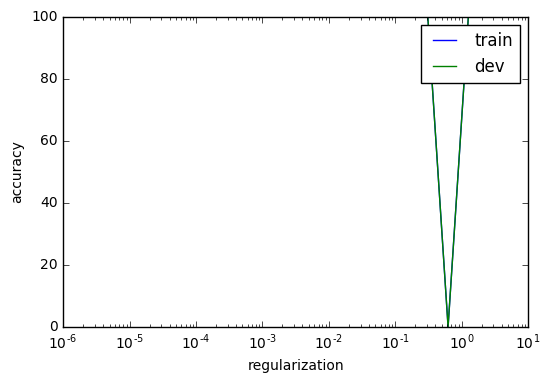

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from cs224d.data_utils import *

from q3_sgd import load_saved_params, sgd
from q4_softmaxreg import softmaxRegression, getSentenceFeature, accuracy, softmax_wrapper



# Try different regularizations and pick the best!
# NOTE: fill in one more "your code here" below before running!
REGULARIZATION = None   # Assign a list of floats in the block below
### YOUR CODE HERE
REGULARIZATION = np.logspace(-6,0.1,21)
REGULARIZATION = np.hstack([0,REGULARIZATION])
### END YOUR CODE

# Load the dataset
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# Load the word vectors we trained earlier
_, wordVectors0, _ = load_saved_params()
N = wordVectors0.shape[0]//2
#assert nWords == N
wordVectors = (wordVectors0[:N,:] + wordVectors0[N:,:])
dimVectors = wordVectors.shape[1]

# Load the train set
trainset = dataset.getTrainSentences()
nTrain = len(trainset)
trainFeatures = np.zeros((nTrain, dimVectors))
trainLabels = np.zeros((nTrain,), dtype=np.int32)
for i in range(nTrain):
    words, trainLabels[i] = trainset[i]
    trainFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

# Prepare dev set features
devset = dataset.getDevSentences()
nDev = len(devset)
devFeatures = np.zeros((nDev, dimVectors))
devLabels = np.zeros((nDev,), dtype=np.int32)
for i in range(nDev):
    words, devLabels[i] = devset[i]
    devFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

# Try our regularization parameters
results = []
for regularization in REGULARIZATION:
    random.seed(3141)
    np.random.seed(59265)
    weights = np.random.randn(dimVectors, 5)
    print("Training for reg=%f" % regularization)

    # We will do batch optimization
    weights = sgd(lambda weights: softmax_wrapper(trainFeatures, trainLabels,
        weights, regularization), weights, 3.0, 10000, PRINT_EVERY=100)

    # Test on train set
    _, _, pred = softmaxRegression(trainFeatures, trainLabels, weights)
    trainAccuracy = accuracy(trainLabels, pred)
    print("Train accuracy (%%): %f" % trainAccuracy)

    # Test on dev set
    _, _, pred = softmaxRegression(devFeatures, devLabels, weights)
    devAccuracy = accuracy(devLabels, pred)
    print("Dev accuracy (%%): %f" % devAccuracy)

    # Save the results and weights
    results.append({
        "reg" : regularization,
        "weights" : weights,
        "train" : trainAccuracy,
        "dev" : devAccuracy})

# Print the accuracies
print("")
print("=== Recap ===")
print("Reg\t\tTrain\t\tDev")
for result in results:
    print("%E\t%0.4g\t%0.4g" % (
        result["reg"],
        result["train"],
        result["dev"]))
for result in results:
    print("%0.2e & %0.4g & %0.4g \\\\" % (
        result["reg"],
        result["train"],
        result["dev"]))
print("")

# Pick the best regularization parameters
BEST_REGULARIZATION = None
BEST_WEIGHTS = None

### YOUR CODE HERE
sorted_results = sorted(results, key=lambda x: x['dev'],reverse=True)
BEST_REGULARIZATION = sorted_results[0]['reg']
BEST_WEIGHTS = sorted_results[0]['weights']
### END YOUR CODE

# Test your findings on the test set
testset = dataset.getTestSentences()
nTest = len(testset)
testFeatures = np.zeros((nTest, dimVectors))
testLabels = np.zeros((nTest,), dtype=np.int32)
for i in range(nTest):
    words, testLabels[i] = testset[i]
    testFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)

_, _, pred = softmaxRegression(testFeatures, testLabels, BEST_WEIGHTS)
print("Best regularization value: %E" % BEST_REGULARIZATION)
print("Test accuracy (%%): %f" % accuracy(testLabels, pred))

# Make a plot of regularization vs accuracy
plt.plot(REGULARIZATION, [x["train"] for x in results])
plt.plot(REGULARIZATION, [x["dev"] for x in results])
plt.xscale('log')
plt.xlabel("regularization")
plt.ylabel("accuracy")
plt.legend(['train', 'dev'], loc='upper right')
plt.savefig("q4_reg_v_acc.png")
plt.show()